<a href="https://colab.research.google.com/github/s528661/nlp100_with_alpha/blob/main/nlp100_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 50. データの入手・整形
News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

- ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
- 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
- 抽出された事例をランダムに並び替える．
- 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [ ]:
!pip install mecab-python3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 6.0 MB/s eta 0:00:00


In [32]:
import re,sys,os

import pickle
import time
import copy

import math
import random
import string

from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import scipy as scp

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn import feature_extraction, preprocessing

from sklearn import svm
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, f1_score
from sklearn.metrics import accuracy_score,  precision_score, recall_score, confusion_matrix, roc_auc_score

# import dask.array as da

import lightgbm as lgb

# Neural Language Processing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest

from sklearn.linear_model import RidgeClassifier
import MeCab

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip --no-check-certificate
!unzip ./NewsAggregatorDataset.zip

--2023-11-13 10:15:45--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas     [  <=>               ]  27.87M  85.8MB/s    in 0.3s    

2023-11-13 10:15:45 (85.8 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203]

Archive:  ./NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [ ]:
data = pd.read_csv('newsCorpora.csv',delimiter='\t',header=None,
                 names=["ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY", "HOSTNAME", "TIMESTAMP"])

In [ ]:
data

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027
...,...,...,...,...,...,...,...,...
422414,422933,Surgeons to remove 4-year-old's rib to rebuild...,http://www.cbs3springfield.com/story/26378648/...,WSHM-TV,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.cbs3springfield.com,1409229190251
422415,422934,Boy to have surgery on esophagus after battery...,http://www.wlwt.com/news/boy-to-have-surgery-o...,WLWT Cincinnati,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.wlwt.com,1409229190508
422416,422935,Child who swallowed battery to have reconstruc...,http://www.newsnet5.com/news/local-news/child-...,NewsNet5.com,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.newsnet5.com,1409229190771
422417,422936,Phoenix boy undergoes surgery to repair throat...,http://www.wfsb.com/story/26368078/phoenix-boy...,WFSB,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.wfsb.com,1409229191071


In [ ]:
fix_data = data[data['PUBLISHER'].isin(["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"])]

In [ ]:
train_all, test = train_test_split(fix_data, test_size=0.1, shuffle=True)

In [ ]:
train, valid = train_test_split(train_all, test_size=0.1, shuffle=True)

In [ ]:
train.to_csv("train.txt", sep="\t", index=False, header=None)
valid.to_csv("valid.txt", sep="\t", index=False, header=None)
test.to_csv("test.txt", sep="\t", index=False, header=None)

# 51. 特徴量抽出

学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [ ]:
def preprocessing(text):
  text = "".join([i for i in text if i not in string.punctuation])
  text = text.lower()
  text = re.sub("[0-9]+", "", text)
  return text

In [ ]:
fix_data['pTITLE'] = fix_data['TITLE'].apply(lambda x: preprocessing(x))

<ipython-input-22-0330034268ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fix_data['pTITLE'] = fix_data['TITLE'].apply(lambda x: preprocessing(x))


In [ ]:
fix_data

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,pTITLE
12,13,Europe reaches crunch point on banking union,http://in.reuters.com/article/2014/03/10/eu-ba...,Reuters,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,in.reuters.com,1394470501755,europe reaches crunch point on banking union
13,14,ECB FOCUS-Stronger euro drowns out ECB's messa...,http://in.reuters.com/article/2014/03/10/ecb-p...,Reuters,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,in.reuters.com,1394470501948,ecb focusstronger euro drowns out ecbs message...
19,20,"Euro Anxieties Wane as Bunds Top Treasuries, S...",http://www.businessweek.com/news/2014-03-10/ge...,Businessweek,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,www.businessweek.com,1394470503148,euro anxieties wane as bunds top treasuries sp...
20,21,Noyer Says Strong Euro Creates Unwarranted Eco...,http://www.businessweek.com/news/2014-03-10/no...,Businessweek,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,www.businessweek.com,1394470503366,noyer says strong euro creates unwarranted eco...
29,30,REFILE-Bad loan triggers key feature in ECB ba...,http://in.reuters.com/article/2014/03/10/euroz...,Reuters,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,in.reuters.com,1394470505070,refilebad loan triggers key feature in ecb ban...
...,...,...,...,...,...,...,...,...,...
422300,422819,UN: Ebola Could Eventually Infect 20000 People,http://www.huffingtonpost.com/2014/08/28/ebola...,Huffington Post,m,dhhnSHVoyA7ENBM3boDX_D_-3PV6M,www.huffingtonpost.com,1409228423333,un ebola could eventually infect people
422301,422820,"Ebola toll tops 1550, continues to accelerate ...",http://in.reuters.com/article/2014/08/28/healt...,Reuters,m,dhhnSHVoyA7ENBM3boDX_D_-3PV6M,in.reuters.com,1409228423827,ebola toll tops continues to accelerate who
422302,422821,"UPDATE 1-Ebola toll tops 1550, outbreak accele...",http://in.reuters.com/article/2014/08/28/healt...,Reuters,m,dhhnSHVoyA7ENBM3boDX_D_-3PV6M,in.reuters.com,1409228424525,update ebola toll tops outbreak accelerates who
422309,422828,"Ebola Cases May Surpass 20000, WHO Says in Upd...",http://www.businessweek.com/news/2014-08-28/eb...,Businessweek,m,dhhnSHVoyA7ENBM3boDX_D_-3PV6M,www.businessweek.com,1409228426943,ebola cases may surpass who says in updated plan


In [25]:
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1, 2)) # 1-gram, 2-gramでTfidfを計算
X = vectorizer.fit_transform(fix_data['pTITLE']).toarray()
X = pd.DataFrame(X, columns=vectorizer.get_feature_names_out())

In [26]:
X

,aa,aaliyah,abbvie,abc,about,about the,about to,above,abramson,abuse,...,young,your,your mother,yr,yr high,yuan,zac,zac efron,zendaya,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
X_train_all, X_test = train_test_split(X, test_size=0.1, shuffle=True)

In [30]:
X_train, X_val = train_test_split(X_train_all, test_size=0.1, shuffle=True)

In [31]:
X_train.to_csv("train.feature.txt", sep="\t", index=False, header=None)
X_val.to_csv("valid.feature.txt", sep="\t", index=False, header=None)
X_test.to_csv("test.feature.txt", sep="\t", index=False, header=None)

# 52. 学習

51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [63]:
y_train = fix_data.iloc[X_train.index]['CATEGORY']
y_val = fix_data.iloc[X_val.index]['CATEGORY']
y_test = fix_data.iloc[X_test.index]['CATEGORY']

In [64]:
model = LogisticRegression(random_state=64, max_iter=10000)
model.fit(X_train,y_train)

LogisticRegression(max_iter=10000, random_state=64)

# 53. 予測

52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [72]:
y_val_pred = model.predict(X_val)
y_val_pred_proba = model.predict_proba(X_val)

In [70]:
y_val_pred

array(['e', 'b', 'b', ..., 'b', 'e', 'e'], dtype=object)

In [71]:
y_val_pred_proba

array([[0.00559567, 0.98819103, 0.00454823, 0.00166508],
       [0.76438223, 0.13168537, 0.02989488, 0.07403752],
       [0.89187022, 0.0545339 , 0.01539528, 0.0382006 ],
       ...,
       [0.6202358 , 0.24627774, 0.04304574, 0.09044072],
       [0.03663322, 0.9324882 , 0.01121617, 0.01966241],
       [0.22172558, 0.41793446, 0.24749651, 0.11284346]])

# 54. 正解率の計測

52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [73]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [79]:
"Train Score: {}".format(accuracy_score(y_train_pred,y_train))

'Train Score: 0.9253123553910226'

In [78]:
"Test Score: {}".format(accuracy_score(y_test_pred,y_test))

'Test Score: 0.8845577211394303'

# 55. 混同行列の作成

52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [82]:
print("Train Confusion Matrix")
print(confusion_matrix(y_train_pred,y_train))

Train Confusion Matrix
[[4395   58   95  209]
 [  88 4226  129  137]
 [   8    0  479    6]
 [  56    9   12  898]]


<Axes: >

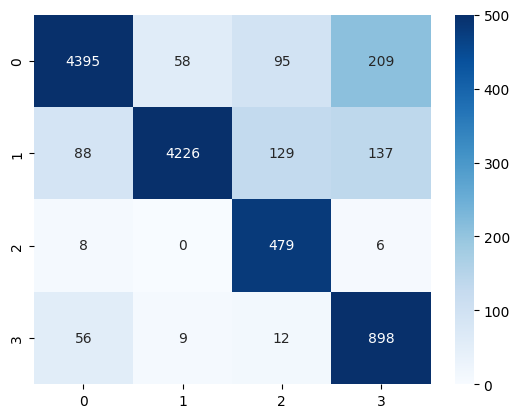

In [86]:
sns.heatmap(confusion_matrix(y_train_pred,y_train), vmin=0, vmax=500, annot=True, fmt='d', cmap='Blues')

In [83]:
print("Test Confusion Matrix")
print(confusion_matrix(y_test_pred,y_test))

Test Confusion Matrix
[[531  14  23  36]
 [ 16 515  21  21]
 [  2   1  52   1]
 [ 12   4   3  82]]


<Axes: >

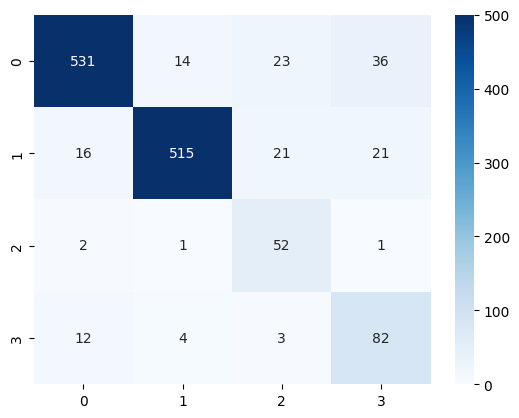

In [87]:
sns.heatmap(confusion_matrix(y_test_pred,y_test), vmin=0, vmax=500, annot=True, fmt='d', cmap='Blues')

# 56. 適合率，再現率，F1スコアの計測

52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [88]:
micro_pricision = precision_score(y_test_pred, y_test, average='micro')
macro_pricision = precision_score(y_test_pred, y_test, average='macro')
print("適合率")
print("マイクロ平均 : {}".format(micro_pricision))
print("マクロ平均 : {}".format(macro_pricision))

適合率
マイクロ平均 : 0.8845577211394303
マクロ平均 : 0.7554775876983412


In [89]:
micro_recall = recall_score(y_test_pred, y_test, average='micro')
macro_recall = recall_score(y_test_pred, y_test, average='macro')
print("再現率")
print("マイクロ平均 : {}".format(micro_recall))
print("マクロ平均 : {}".format(macro_recall))

再現率
マイクロ平均 : 0.8845577211394303
マクロ平均 : 0.8795925122623165


In [90]:
micro_f1 = f1_score(y_test_pred, y_test, average='micro')
macro_f1 = f1_score(y_test_pred, y_test, average='macro')
print("F1スコア")
print("マイクロ平均 : {}".format(micro_f1))
print("マクロ平均 : {}".format(macro_f1))

F1スコア
マイクロ平均 : 0.8845577211394303
マクロ平均 : 0.7983740719597541


# 57. 特徴量の重みの確認

52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ

In [ ]:
features = X_train.columns.values